In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
path = 'C:/Users/alcob/Desktop/BrainStation/Python/BrainStationCapstone/archive/'

folder_list = ['cadesp', 'lattes', 'nfe', 'nfesjppr', 'pje', 'rfb', 'rsc', 'sefazsp', 'sintegrarj', 'tjrs', 'trt3']

In [3]:
class CaptchaLibrary:
    pass

class Captcha:
    def __init__(self, image_list, target_list):
        self.images = image_list
        self.targets = target_list

def GetImages(folder_path, limit = 0):
    """""""""
    This function will return a list containing the first pictures up to a certain 'limit', from the specified folder path.
    If limit is 0 or None it will append all pictures from the folder. 
    """""""""
    count = 0
    
    image_list = []
    
    for filename in glob.glob(path + folder_path + '/*.*'):
        image=cv.imread(filename)
        image_list.append(image)
        
        if limit > 0:
            count += 1
            if count >= limit:
                break
    
    return image_list

def GetTargets(folder_path, limit):
    """""""""
    This function will return a list containing the first filenames (i.e the targets) up to a certain 'limit', from the specified folder path.
    If limit is 0 or None it will append all the filenames from the folder.
    """""""""
    
    count = 0
    
    target_list = []
    
    for filename in glob.glob(path + folder_path + '/*.*'):
        target_list.append(filename)
        
        if limit > 0:
            count += 1
            if count >= limit:
                break
    
    target_list = list(map(lambda x: x.split('\\')[1].split('.')[0], target_list))
    
    return target_list

In [4]:
%%time

X_nn = GetImages('rsc', 0)
y_nn = GetTargets('rsc', 0)

Wall time: 2.12 s


Let's see how a CNN handles our simplest CAPTCHA

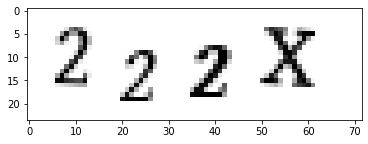

In [5]:
plt.imshow(cv.cvtColor(X_nn[0], cv.COLOR_BGR2RGB))

In [6]:
y_nn[0]

'222x'

In [7]:
kernel = np.ones((2,2),np.uint8)

for i in range(len(X_nn)):
    X_nn[i] = X_nn[i].reshape(24, 72, 3) 

X_nn = np.asarray(X_nn)

In [9]:
# Normalize X:
for i in range(len(X_nn)):
    X_nn[i] = X_nn[i]/255

In [10]:
# Set the labels as lists
for label_index in range(len(y_nn)):
    y_nn[label_index] = list(y_nn[label_index])

This will be the key by which we encode / decode as not all captchas use the same characters we will need to set different ones accordingly

In [11]:
items = np.unique(y_nn)

items = list(items)

Getting a len will tell us how many nodes we need at each output layer.

In [12]:
len(items)

32

In [13]:
def encode_label_list(label, items):
    encoded_label = []
    for i in label:
        encoded_label.append(items.index(i))
    return encoded_label

def decode_label_list(label, items_key):
    decoded_label = []
    for i in label:
        decoded_label.append(items[i])
    return decoded_label

In [15]:
y_nn_encoded = list()

for label in y_nn:
    y_nn_encoded.append(np.array(encode_label_list(label, items)))

In [16]:
for i in range(10):
    print(y_nn[i], ' : ', y_nn_encoded[i])

['2', '2', '2', 'x']  :  [ 0  0  0 29]
['2', '2', '6', 'u']  :  [ 0  0  4 26]
['2', '2', '7', '4']  :  [0 0 5 2]
['2', '2', 'a', '6']  :  [0 0 8 4]
['2', '2', 'b', 'j']  :  [ 0  0  9 16]
['2', '2', 'h', 's']  :  [ 0  0 15 24]
['2', '2', 'k', 'd']  :  [ 0  0 17 11]
['2', '2', 'l', '9']  :  [ 0  0 18  7]
['2', '2', 'n', 'r']  :  [ 0  0 20 23]
['2', '2', 'p', 'l']  :  [ 0  0 21 18]


In [17]:
image_shape = X_nn[0].shape

In [18]:
input_layer = Input(shape = image_shape)

_ = Conv2D(16, kernel_size=(3, 3), activation = 'relu', input_shape = image_shape)(input_layer)
_ = MaxPooling2D(pool_size=(2, 2))(_)
_ = Dropout(0.2)(_)
_ = Conv2D(32, (3, 3), activation='relu')(_)
_ = MaxPooling2D(pool_size=(2, 2))(_)
_ = Dropout(0.2)(_)
_ = Conv2D(64, (3, 3), activation='relu')(_)
_ = MaxPooling2D(pool_size=(2, 2))(_)
_ = Dropout(0.2)(_)

flat = Flatten()(_)

# Because we are woorking with a multi-label classification, we will need one branch layer per output.
# Each output will branch out of our flatten layer.
_ = Dense(64, activation='relu')(flat)
output_0 = Dense(32, activation='softmax', name = 'output_0')(_)

_ = Dense(64, activation='relu')(flat)
output_1 = Dense(32, activation='softmax', name = 'output_1')(_)

_ = Dense(64, activation='relu')(flat)
output_2 = Dense(32, activation='softmax', name = 'output_2')(_)

_ = Dense(64, activation='relu')(flat)
output_3 = Dense(32, activation='softmax', name = 'output_3')(_)


In [19]:
# For this to work we need to set a dictionary with the name of our outputs as keys
# and the loss function as each output's value.
loss_dict = dict()
for i in range(4):
    loss_dict['output_' + str(i)] = 'sparse_categorical_crossentropy'

In [20]:
model = Model(inputs = input_layer, outputs = [output_0, output_1, output_2, output_3])
model.compile(loss = loss_dict,
                      optimizer = 'Adam',
                      metrics = ['accuracy'])

In [21]:
y_nn_encoded = pd.DataFrame(y_nn_encoded)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_nn, y_nn_encoded, test_size = 0.1)

In [23]:
early_stop = EarlyStopping(monitor='loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)

In [24]:
history = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3]],
                    epochs = 50,
                    verbose = 1,
                    validation_split = 0.1,
                    callbacks=[early_stop])

Epoch 1/50
138/138 [==============================] - 4s 32ms/step - loss: 13.5749 - output_0_loss: 3.1555 - output_1_loss: 3.4722 - output_2_loss: 3.4729 - output_3_loss: 3.4743 - output_0_accuracy: 0.0562 - output_1_accuracy: 0.0331 - output_2_accuracy: 0.0340 - output_3_accuracy: 0.0311 - val_loss: 13.4601 - val_output_0_loss: 3.0729 - val_output_1_loss: 3.4555 - val_output_2_loss: 3.4667 - val_output_3_loss: 3.4651 - val_output_0_accuracy: 0.0754 - val_output_1_accuracy: 0.0428 - val_output_2_accuracy: 0.0448 - val_output_3_accuracy: 0.0387
Epoch 2/50
138/138 [==============================] - 4s 27ms/step - loss: 13.3444 - output_0_loss: 3.0433 - output_1_loss: 3.4331 - output_2_loss: 3.4330 - output_3_loss: 3.4350 - output_0_accuracy: 0.0644 - output_1_accuracy: 0.0496 - output_2_accuracy: 0.0428 - output_3_accuracy: 0.0492 - val_loss: 12.5817 - val_output_0_loss: 2.9145 - val_output_1_loss: 3.2444 - val_output_2_loss: 3.1803 - val_output_3_loss: 3.2425 - val_output_0_accuracy: 0

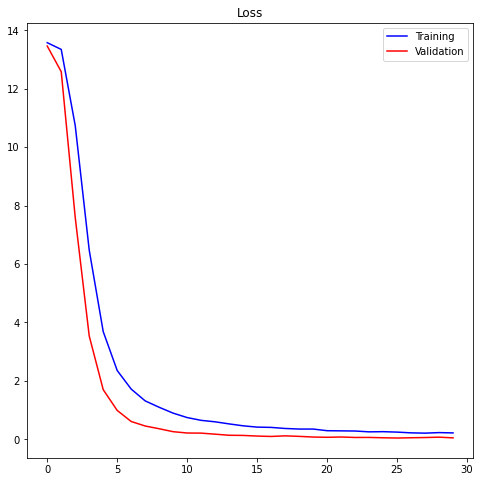

In [25]:
plt.figure(figsize= (8, 8))

plt.plot(history.history['loss'], color='b', label="Training")
plt.plot(history.history['val_loss'], color='r', label="Validation")
plt.title('Loss')

plt.legend()

plt.show()

In [26]:
def predict_captcha(model, X, num_labels, items_key):
    ''''
    Uses a pretrained model to give a full prediction of each Captcha in X.
    
    ''''
    predictions = model.predict(X)
    
    labeled_predictions = []
    
    for i in range(len(X)):
        predicted_label=[]
        
        # Argmax will tell us the index that has the highest probability of being the correct character
        # This index correscponds to the key used to decode it.
        for j in range(num_labels):
            predicted_label.append(predictions[j][i].argmax())
        
        predicted_label = ''.join(decode_label_list(predicted_label, items_key))
        
        labeled_predictions.append(predicted_label)
    
    return labeled_predictions

In [27]:
predicted_captcha = predict_captcha(model, X_test, 4, items)

In [28]:
y_test = y_test.to_numpy().tolist()

true_label = []
for y in y_test:
    true_label.append(''.join(decode_label_list(y, items)))

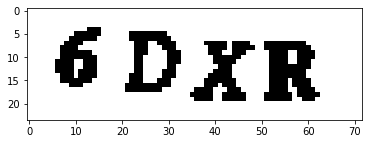

In [29]:
plt.imshow(cv.cvtColor(X_test[0]*255, cv.COLOR_BGR2RGB))

In [30]:
predicted_captcha[0]

'6dxr'

In [31]:
true_label[0]

'6dxr'

In [32]:
accuracy_score(true_label, predicted_captcha)

0.9908256880733946

We will repeat these steps on some of the other styles of CAPTCHA. So we define a function to train a model depending of the parameter's in the images and labels we want to train on.

In [136]:
def TrainBranchedCNN(train_features, train_labels, max_epochs = 25):
    '''''
    Will create a NN based on the train feature and label. Will generate outputs based on the number of labels 
    '''''
    # Here we collect the parameters the model will need to be based on
    image_shape = train_features[0].shape
    n_labels = train_labels.shape[1]
    
    output_list = []
    
    loss_dict = dict()
    for i in range(n_labels):
        loss_dict['output_' + str(i)] = 'sparse_categorical_crossentropy'
    
    n_classes = len(np.unique(train_labels))
    
    input_layer = Input(shape = image_shape)
    
    _ = Conv2D(16, kernel_size=(3, 3), activation = 'relu', input_shape = image_shape)(input_layer)
    _ = MaxPooling2D(pool_size=(2, 2))(_)
    _ = Dropout(0.2)(_)
    _ = Conv2D(32, (3, 3), activation='relu')(_)
    _ = MaxPooling2D(pool_size=(2, 2))(_)
    _ = Dropout(0.2)(_)
    _ = Conv2D(64, (3, 3), activation='relu')(_)
    _ = MaxPooling2D(pool_size=(2, 2))(_)
    _ = Dropout(0.2)(_)
    
    flat = Flatten()(_)

    for i in range(n_labels):
        _ = Dense(128, activation='relu')(flat)
        _ = Dense(64, activation='relu')(_)
        output_list.append(Dense(n_classes, activation='softmax', name = 'output_' + str(i))(_))
    
    
    model = Model(inputs = input_layer, outputs = output_list)
    
    model.compile(loss = loss_dict,
                      optimizer = 'Adam',
                      metrics = ['accuracy'])
    
    early_stop = EarlyStopping(monitor='loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)
    
    model.fit(train_features, [train_labels[i] for i in range(n_labels)],
                    epochs = max_epochs,
                    verbose = 1,
                    validation_split = 0.1,
                    callbacks=[early_stop])
    
    return model

----
**We will repeat the steps above on each CAPTCHA we werent able to solve in the first notebook**

In [34]:
X_lattes = GetImages('lattes', 0)
y_lattes = GetTargets('lattes', 0)

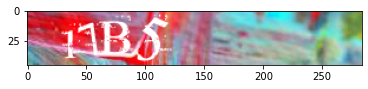

In [35]:
plt.imshow(cv.cvtColor(X_lattes[0], cv.COLOR_BGR2RGB))

In [36]:
X_lattes[0].shape

(46, 284, 3)

In [37]:
for i in range(len(X_lattes)):
    X_lattes[i] = cv.cvtColor(X_lattes[i], cv.COLOR_BGR2GRAY)
    X_lattes[i] = X_lattes[i].reshape(46, 284, 1) 

In [38]:
def PrepareForTraining(X, y):
    
    X = np.asarray(X)
    
    for i in range(len(X)):
        X[i] = X[i]/255
    
    for label_index in range(len(y)):
        y[label_index] = list(y[label_index])
    
    return X, y

In [39]:
X_lattes, y_lattes = PrepareForTraining(X_lattes, y_lattes)

In [40]:
items = list(np.unique(y_lattes))

In [41]:
y_encoded = list()

for label in y_lattes:
    y_encoded.append(np.array(encode_label_list(label, items)))

y_lattes = pd.DataFrame(y_encoded)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_lattes, y_lattes, test_size = 0.2)

In [43]:
%%time
model_lattes = TrainBranchedCNN(X_train, y_train, max_epochs=5)

Epoch 1/5
545/545 [==============================] - 113s 208ms/step - loss: 2.8463 - output_0_loss: 0.3488 - output_1_loss: 0.6986 - output_2_loss: 0.9583 - output_3_loss: 0.8406 - output_0_accuracy: 0.9073 - output_1_accuracy: 0.8030 - output_2_accuracy: 0.7368 - output_3_accuracy: 0.7617 - val_loss: 0.2016 - val_output_0_loss: 0.0099 - val_output_1_loss: 0.0216 - val_output_2_loss: 0.1196 - val_output_3_loss: 0.0505 - val_output_0_accuracy: 0.9985 - val_output_1_accuracy: 0.9943 - val_output_2_accuracy: 0.9757 - val_output_3_accuracy: 0.9871
Epoch 2/5
545/545 [==============================] - 116s 213ms/step - loss: 0.2203 - output_0_loss: 0.0076 - output_1_loss: 0.0381 - output_2_loss: 0.1293 - output_3_loss: 0.0454 - output_0_accuracy: 0.9978 - output_1_accuracy: 0.9909 - output_2_accuracy: 0.9646 - output_3_accuracy: 0.9884 - val_loss: 0.0942 - val_output_0_loss: 1.1273e-05 - val_output_1_loss: 0.0129 - val_output_2_loss: 0.0691 - val_output_3_loss: 0.0122 - val_output_0_accurac

In [44]:
predicted_captcha_lattes = predict_captcha(model_lattes, X_test, 4, items)

In [45]:
y_test = y_test.to_numpy().tolist()

true_label = []
for y in y_test:
    true_label.append(''.join(decode_label_list(y, items)))

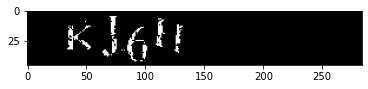

In [46]:
plt.imshow(cv.cvtColor(X_test[0]*255, cv.COLOR_BGR2RGB))

In [47]:
predicted_captcha_lattes[0]

'KJ6H'

In [48]:
true_label[0]

'KJ6H'

In [49]:
accuracy_score(true_label, predicted_captcha_lattes)

0.9888452799008469

-----

In [50]:
X_pje = GetImages('pje', 0)
y_pje = GetTargets('pje', 0)

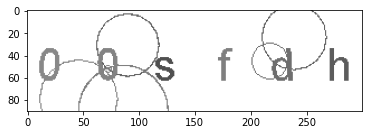

In [51]:
plt.imshow(cv.cvtColor(X_pje[0], cv.COLOR_BGR2RGB))

In [52]:
X_pje[0].shape

(90, 300, 3)

In [53]:
for i in range(len(X_pje)):
    X_pje[i] = cv.cvtColor(X_pje[i], cv.COLOR_BGR2GRAY)
    X_pje[i] =cv.dilate(X_pje[i],kernel,iterations=1)
    _ , X_pje[i] = cv.threshold(X_pje[i], 160, 255, cv.THRESH_BINARY_INV)
    X_pje[i] = X_pje[i].reshape(90, 300, 1)
    

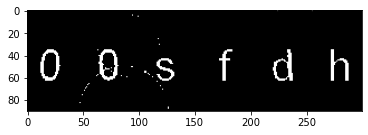

In [54]:
plt.imshow(cv.cvtColor(X_pje[0], cv.COLOR_BGR2RGB))

In [55]:
X_pje, y_pje = PrepareForTraining(X_pje, y_pje)

items = list(np.unique(y_pje))

y_encoded = list()

for label in y_pje:
    y_encoded.append(np.array(encode_label_list(label, items)))

y_pje = pd.DataFrame(y_encoded)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_pje, y_pje, test_size = 0.2)

In [59]:
%%time
model_pje = TrainBranchedCNN(X_train, y_train, max_epochs=10)

Epoch 1/10
225/225 [==============================] - 105s 465ms/step - loss: 8.8177 - output_0_loss: 1.4965 - output_1_loss: 1.4803 - output_2_loss: 1.3081 - output_3_loss: 1.4690 - output_4_loss: 1.3300 - output_5_loss: 1.7338 - output_0_accuracy: 0.5789 - output_1_accuracy: 0.6018 - output_2_accuracy: 0.6335 - output_3_accuracy: 0.5894 - output_4_accuracy: 0.6303 - output_5_accuracy: 0.5046 - val_loss: 0.5844 - val_output_0_loss: 0.0552 - val_output_1_loss: 0.0575 - val_output_2_loss: 0.1204 - val_output_3_loss: 0.0681 - val_output_4_loss: 0.1049 - val_output_5_loss: 0.1783 - val_output_0_accuracy: 0.9850 - val_output_1_accuracy: 0.9862 - val_output_2_accuracy: 0.9638 - val_output_3_accuracy: 0.9775 - val_output_4_accuracy: 0.9700 - val_output_5_accuracy: 0.9413
Epoch 2/10
225/225 [==============================] - 107s 474ms/step - loss: 0.3663 - output_0_loss: 0.0585 - output_1_loss: 0.0367 - output_2_loss: 0.0750 - output_3_loss: 0.0511 - output_4_loss: 0.0668 - output_5_loss: 0.

In [60]:
predicted_captcha_pje = predict_captcha(model_pje, X_test, 6, items)

y_test = y_test.to_numpy().tolist()

true_label = []
for y in y_test:
    true_label.append(''.join(decode_label_list(y, items)))

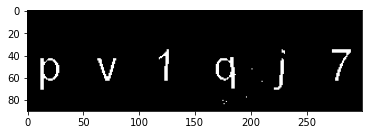

In [61]:
plt.imshow(cv.cvtColor(X_test[0]*255, cv.COLOR_BGR2RGB))

In [62]:
predicted_captcha_pje[0]

'pv1qj7'

In [63]:
true_label[0]

'pv1qj7'

In [64]:
accuracy_score(true_label, predicted_captcha_pje)

0.9935

----

In [65]:
X_tjrs = GetImages('tjrs', 0)
y_tjrs = GetTargets('tjrs', 0)

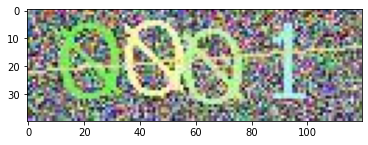

In [66]:
plt.imshow(cv.cvtColor(X_tjrs[0], cv.COLOR_BGR2RGB))

In [67]:
X_tjrs[0].shape

(40, 120, 3)

In [68]:
for i in range(len(X_tjrs)):
    X_tjrs[i] = cv.cvtColor(X_tjrs[i], cv.COLOR_BGR2GRAY)
    _ , X_tjrs[i] = cv.threshold(X_tjrs[i], 160, 255, cv.THRESH_BINARY_INV)
    X_tjrs[i] = X_tjrs[i].reshape(40, 120, 1)

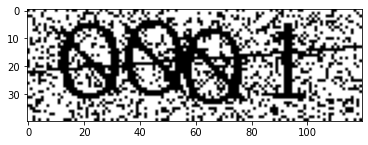

In [69]:
plt.imshow(cv.cvtColor(X_tjrs[0], cv.COLOR_BGR2RGB))

In [70]:
X_tjrs, y_tjrs = PrepareForTraining(X_tjrs, y_tjrs)

items = list(np.unique(y_tjrs))

y_encoded = list()

for label in y_tjrs:
    y_encoded.append(np.array(encode_label_list(label, items)))

y_tjrs = pd.DataFrame(y_encoded)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_tjrs, y_tjrs, test_size = 0.2)

In [72]:
%%time
model_tjrs = TrainBranchedCNN(X_train, y_train, max_epochs=25)

Epoch 1/25
120/120 [==============================] - 10s 80ms/step - loss: 9.2204 - output_0_loss: 2.3043 - output_1_loss: 2.3052 - output_2_loss: 2.3054 - output_3_loss: 2.3055 - output_0_accuracy: 0.1132 - output_1_accuracy: 0.0993 - output_2_accuracy: 0.1074 - output_3_accuracy: 0.1100 - val_loss: 9.2023 - val_output_0_loss: 2.3006 - val_output_1_loss: 2.3001 - val_output_2_loss: 2.3004 - val_output_3_loss: 2.3013 - val_output_0_accuracy: 0.0939 - val_output_1_accuracy: 0.0892 - val_output_2_accuracy: 0.1338 - val_output_3_accuracy: 0.1103_1_loss: 2.3068 - output_2_loss: 2.3078 - output_3_loss: 2.3089 - output_0_accuracy: 0.1075 - output_1_accuracy: 0.1075 
Epoch 2/25
120/120 [==============================] - 9s 79ms/step - loss: 8.6235 - output_0_loss: 2.0226 - output_1_loss: 2.1583 - output_2_loss: 2.2112 - output_3_loss: 2.2315 - output_0_accuracy: 0.2739 - output_1_accuracy: 0.2028 - output_2_accuracy: 0.1722 - output_3_accuracy: 0.1626 - val_loss: 6.0765 - val_output_0_loss: 

In [73]:
predicted_captcha_tjrs = predict_captcha(model_tjrs, X_test, 4, items)

y_test = y_test.to_numpy().tolist()

true_label = []
for y in y_test:
    true_label.append(''.join(decode_label_list(y, items)))

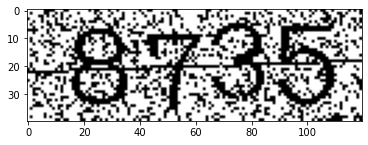

In [74]:
plt.imshow(cv.cvtColor(X_test[0]*255, cv.COLOR_BGR2RGB))

In [75]:
predicted_captcha_tjrs[0]

'8735'

In [76]:
accuracy_score(true_label, predicted_captcha_tjrs)

0.9576669802445907

----

In [159]:
X_rfb = GetImages('rfb', 0)
y_rfb = GetTargets('rfb', 0)

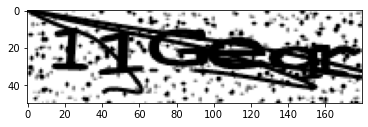

In [160]:
plt.imshow(cv.cvtColor(X_rfb[0], cv.COLOR_BGR2RGB))

In [161]:
X_rfb[0].shape

(50, 180, 3)

In [162]:
for i in range(len(X_rfb)):
    X_rfb[i] = cv.cvtColor(X_rfb[i], cv.COLOR_BGR2GRAY)
    X_rfb[i] =cv.dilate(X_rfb[i],kernel,iterations=2)
    X_rfb[i] = X_rfb[i].reshape(50, 180, 1)

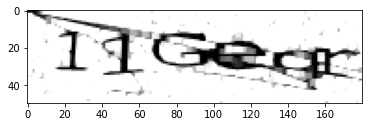

In [163]:
plt.imshow(cv.cvtColor(X_rfb[0], cv.COLOR_BGR2RGB))

In [164]:
X_rfb, y_rfb = PrepareForTraining(X_rfb, y_rfb)

items = list(np.unique(y_rfb))

y_encoded = list()

for label in y_rfb:
    y_encoded.append(np.array(encode_label_list(label, items)))

y_rfb = pd.DataFrame(y_encoded)

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X_rfb, y_rfb, test_size = 0.2)

In [152]:
%%time
model_rfb = TrainBranchedCNN(X_train, y_train, max_epochs=50)

Epoch 1/50
309/309 [==============================] - 51s 165ms/step - loss: 19.7745 - output_0_loss: 3.2512 - output_1_loss: 3.2868 - output_2_loss: 3.2645 - output_3_loss: 3.2644 - output_4_loss: 3.2672 - output_5_loss: 3.4404 - output_0_accuracy: 0.0912 - output_1_accuracy: 0.0868 - output_2_accuracy: 0.0912 - output_3_accuracy: 0.0933 - output_4_accuracy: 0.0918 - output_5_accuracy: 0.0530 - val_loss: 12.9494 - val_output_0_loss: 2.1171 - val_output_1_loss: 2.0796 - val_output_2_loss: 1.9113 - val_output_3_loss: 1.9631 - val_output_4_loss: 1.9652 - val_output_5_loss: 2.9131 - val_output_0_accuracy: 0.3309 - val_output_1_accuracy: 0.3428 - val_output_2_accuracy: 0.4029 - val_output_3_accuracy: 0.4120 - val_output_4_accuracy: 0.4020 - val_output_5_accuracy: 0.1623
Epoch 2/50
309/309 [==============================] - 50s 162ms/step - loss: 9.0074 - output_0_loss: 1.4210 - output_1_loss: 1.3300 - output_2_loss: 1.3582 - output_3_loss: 1.3612 - output_4_loss: 1.2753 - output_5_loss: 2.

In [166]:
predicted_captcha_rfb = predict_captcha(model_rfb, X_test, 6, items)

In [167]:
y_test = y_test.to_numpy().tolist()

true_label = []
for y in y_test:
    true_label.append(''.join(decode_label_list(y, items)))

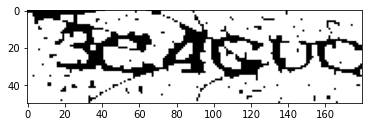

In [168]:
plt.imshow(cv.cvtColor(X_test[0]*255, cv.COLOR_BGR2RGB))

In [169]:
predicted_captcha_rfb[0]

'3c4guc'

In [170]:
accuracy_score(true_label, predicted_captcha_rfb)

0.8151658767772512